# Monet using GAN

In [34]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa
# from kaggle_datasets import KaggleDatasets

if os.path.exists(r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'):
    datapath = r'C:\Users\kuusnin\tempwork\temp\gan-getting-started'
else:
    datapath = r'C:\Users\nikok\Documents\Monet using GAN'

lite = True

In [35]:
tf.__version__

'2.18.0'

## Brief description of the problem and data (5 pts)

*Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.*

In [36]:
monet_files = os.listdir(os.path.join(datapath, 'monet_tfrec'))
photo_files = os.listdir(os.path.join(datapath, 'photo_tfrec'))
monet_filenames = [os.path.join(datapath, 'monet_tfrec', f) for f in monet_files]
photo_filenames = [os.path.join(datapath, 'photo_tfrec', f) for f in photo_files]
print(20*'*', 'Monet paintings', 20*'*')
print('First filename:', monet_files[0], '\nNumber of files:', len(monet_files))
print(20*'*', 'Photos', 20*'*')
print('First filename:', photo_files[0], '\nNumber of files:', len(photo_files))

******************** Monet paintings ********************
First filename: monet00-60.tfrec 
Number of files: 5
******************** Photos ********************
First filename: photo00-352.tfrec 
Number of files: 20


### Figure out the contents of the tfrec files

From the code below we can see that each record/example contains three fields: 
* target: label of the image. Not needed in this work 
* image_name: name of the image
* image: the actual image data

Both of the data sets appear to have the same structure. 

In [37]:
# The following code is adapted from an answer from Microsoft Copilot
import tensorflow as tf
from google.protobuf.json_format import MessageToJson
import json

def iterate_record(dataset):
    # Initialize a counter
    record_count = 0
    # Iterate through the dataset and count the records
    for _ in dataset:
        record_count += 1
    print(f'Total number of records: {record_count}')
    
    # Iterate through the dataset and parse each record
    for raw_record in dataset.take(1):  # Adjust the number to read more records
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        json_message = MessageToJson(example)
        parsed_record = json.loads(json_message)
        print(json.dumps(parsed_record, indent=2)[0:500])

# Create a TFRecordDataset
print(20*'*', 'Monet paintings', 20*'*')
raw_monet_dataset = tf.data.TFRecordDataset(monet_filenames)
iterate_record(raw_monet_dataset)

print(20*'*', 'Photos', 20*'*')
raw_photo_dataset = tf.data.TFRecordDataset(photo_filenames)
iterate_record(raw_photo_dataset)


******************** Monet paintings ********************
Total number of records: 300
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "bW9uZXQ="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MjVjOTkwNDc4Mg=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "value": [
            "/9j/4AAQSkZJRgABAQEBLAEsAAD/2wBDAAIBAQEBAQIBAQECAgICAgQDAgICAgUEBAMEBgUGBgYFBgYGBwkIBgcJBwYGCAsICQoKCgoKBggLDAsKDAkKCgr/2wBDAQICAgICAgUDAwUKBwYHCgo
******************** Photos ********************
Total number of records: 7038
{
  "features": {
    "feature": {
      "target": {
        "bytesList": {
          "value": [
            "cGhvdG8="
          ]
        }
      },
      "image_name": {
        "bytesList": {
          "value": [
            "MGI5MWYzNTljNQ=="
          ]
        }
      },
      "image": {
        "bytesList": {
          "val

We can parse the data now since the structure of the tfrecord is known.

In [38]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["image"] = (tf.cast(example["image"], tf.float32) / 127.5) - 1
    return example

def decode_image(tf_image):
    return ((tf_image['image'].numpy()[0] + 1) * 127.5).astype(int)

monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn).batch(1)
photo_dataset = raw_photo_dataset.map(parse_tfrecord_fn).batch(1)



## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

*Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?*

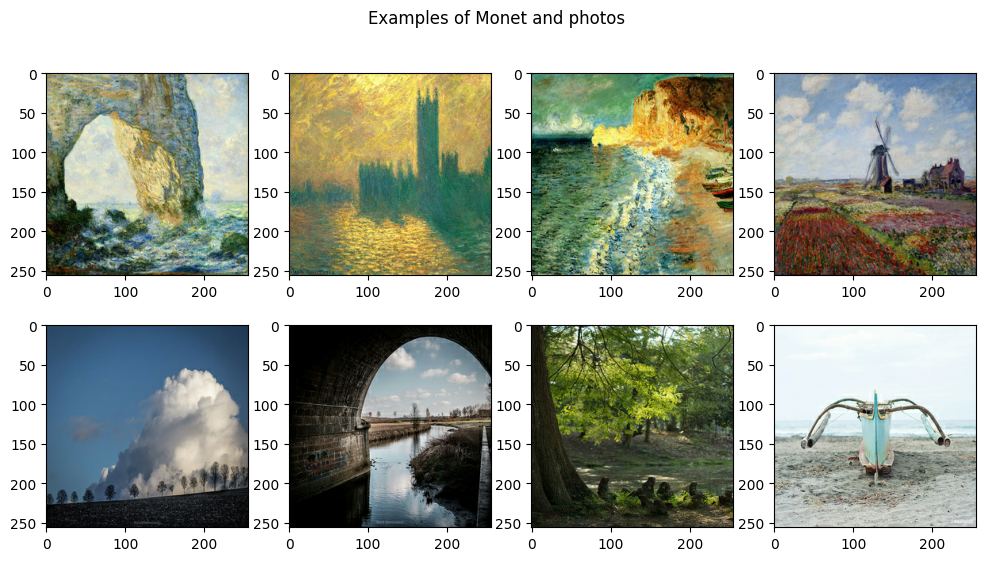

In [39]:
fig = plt.figure(figsize=(12, 6))
i = 0
for data in monet_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(decode_image(data))
    # print(data['image'].shape)
    i += 1
for data in photo_dataset.take(4):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(decode_image(data))
    i += 1
fig.suptitle('Examples of Monet and photos')
plt.show()

In [40]:
dims = []
for data in photo_dataset:
    img = data['image'].numpy().shape[1:]
    dims.append(img)
print('Unique shapes of the photos data:', set(dims))

dims = []
for data in monet_dataset:
    dims.append(data['image'].numpy().shape[1:])
print('Unique shapes of the Monet data:', set(dims))

Unique shapes of the photos data: {(256, 256, 3)}
Unique shapes of the Monet data: {(256, 256, 3)}


In [15]:
def plot_histogram(dataset, title):
    rgb = []
    rgb = [decode_image(d) for d in dataset]
    # for data in dataset:
    #     rgb.append(decode_image(data))
    rgb = np.array(rgb)
    # rgb.shape
    pic_channels = ['red', 'green', 'blue']
    rgb_df = pd.DataFrame()
    for i, clr in enumerate(pic_channels):
        df = pd.DataFrame(rgb[:,:,:,i].ravel(), columns=['val'])
        df['color'] = clr
        rgb_df = pd.concat([rgb_df, df])
    print('Minimum and maximmum values in ' + title + ' data: ', min(rgb_df.val), '&', max(rgb_df.val))
    sns.histplot(rgb_df.sample(1000), x='val', hue='color', bins=30, multiple='dodge', color=['green', 'blue', 'red'])
    plt.grid()
    plt.title('Histogram of ' + title)
    plt.show()



Minimum and maximmum values in sample photos data:  0 & 255


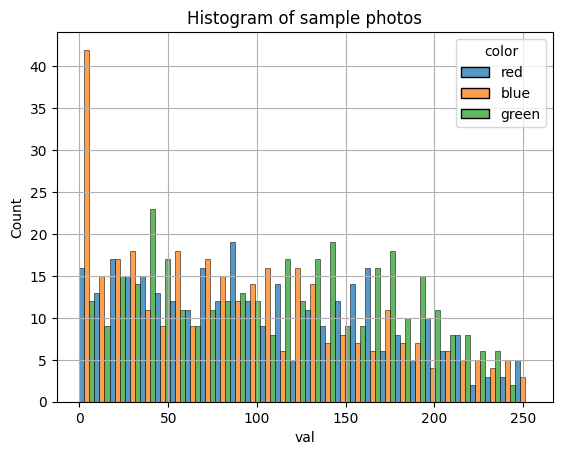

Minimum and maximmum values in Monet paintings data:  0 & 255


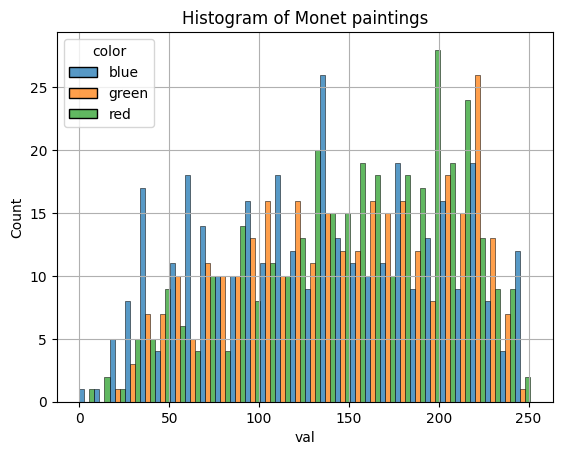

In [17]:
plot_histogram(photo_dataset.take(300), title='sample photos')
plot_histogram(monet_dataset.take(300), title='Monet paintings')


After the EDA is done, we set the batch size of the dataset for training.

In [41]:
monet_dataset = raw_monet_dataset.map(parse_tfrecord_fn).batch(32, drop_remainder=True).shuffle(buffer_size=32).repeat()
photo_dataset = raw_photo_dataset.map(parse_tfrecord_fn).batch(32, drop_remainder=True).shuffle(buffer_size=32).repeat()

## Model Architecture (25 pts)

*Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.*

### Discriminator
Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [42]:
if lite:
    factor = 1/8
else:
    factor = 1
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(int(64 * factor), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(int(128 * factor), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(int(128 * factor), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 8)    │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 16)     │         4,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,953 (89.66 KB)

 Trainable params: 22,953 (89.66 KB)

 Non-trainable params: 0 (0.00 B)

#### Generator

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [43]:
latent_dim = 128
if lite:
    factor = 1/8
else:
    factor = 1
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(int(128 * factor), kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(int(256 * factor), kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(int(512 * factor), kernel_size=4, strides=4, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 16, 16, 16)     │        32,784 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 64, 64, 32)     │         8,224 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 256, 256, 64)   │        32,832 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 256, 256, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 256, 256, 3)    │         4,803 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,135,411 (4.33 MB)

 Trainable params: 1,135,411 (4.33 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
def generator_from_img(latent_dim=128):
    generator = keras.Sequential(
        [
            keras.Input(shape=(256,256,3)),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(512, kernel_size=4, strides=4, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(256, kernel_size=4, strides=4, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(128, kernel_size=4, strides=8, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            # layers.Reshape((8, 8, latent_dim)),
            # layers.Dropout(0.2),
            layers.Flatten(),
            # # layers.Dense(8 * 8 * 128),
            layers.Reshape((1, 1, 128)),
            layers.Conv2DTranspose(128, kernel_size=4, strides=8, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=4, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2DTranspose(512, kernel_size=4, strides=4, padding="same"),
            layers.LeakyReLU(negative_slope=0.2),
            layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
        ],
        name="generator_from_img")
    return generator
generator_from_img = generator_from_img(latent_dim)
generator_from_img.summary()

Model: "generator_from_img"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 256, 256, 3)    │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 512)    │        25,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 64, 64, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 256)    │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 8, 8, 128)      │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_39 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_40 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 64, 64, 256)    │       524,544 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_41 (LeakyReLU)      │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 256, 256, 512)  │     2,097,664 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 256, 256, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 256, 256, 3)    │        38,403 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,094,567 (23.25 MB)

 Trainable params: 6,094,567 (23.25 MB)

 Non-trainable params: 0 (0.00 B)

#### Training

Override the train step.

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [48]:
# with tpu_strategy.scope():
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, image_batches):
        monet_images, photo_images = image_batches
        monet_images = monet_images['image']
        photo_images = photo_images['image']
        batch_size = keras.ops.shape(monet_images)[0]
        
        # Decode photos to fake Monets
        generated_images = self.generator(photo_images)

        # Combine them with real images
        combined_images = keras.ops.concatenate([generated_images, monet_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = keras.ops.concatenate(
            [keras.ops.ones((batch_size, 1)), keras.ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # # Sample random points in the latent space
        # random_latent_vectors = keras.random.normal(
        #     shape=(batch_size, self.latent_dim), seed=self.seed_generator
        # )

        # Assemble labels that say "all real images"
        misleading_labels = keras.ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(photo_images))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


#### Callbacks

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [49]:

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


#### Training

Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [50]:
epochs = 1  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator_from_img, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)), epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

     25/Unknown 514s 20s/step - d_loss: 0.5594 - g_loss: 1.0764

KeyboardInterrupt: 

## Results and Analysis (35 pts)

*Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.*

*Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.*

## Conclusion (15 pts)

*Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?*

# Sources

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
